In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#Loading images from data
# WIN path
PATH = "C:/Users/Lenovo/Desktop/AI/AI_Project/data/"
# Linux path
# PATH = "/home/changsmarter/Desktop/myAI_Project/data/"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob('*/*/*.jpg')))
image_csv = pd.read_csv(PATH+'Raw_Data_JPG.csv')
CLASS_NAME = image_csv.Diagnosis.unique()
print(image_num)
print(CLASS_NAME)

5110
['No Finding' 'TB' 'Heart' 'CA lung' 'Intra' 'Extra']


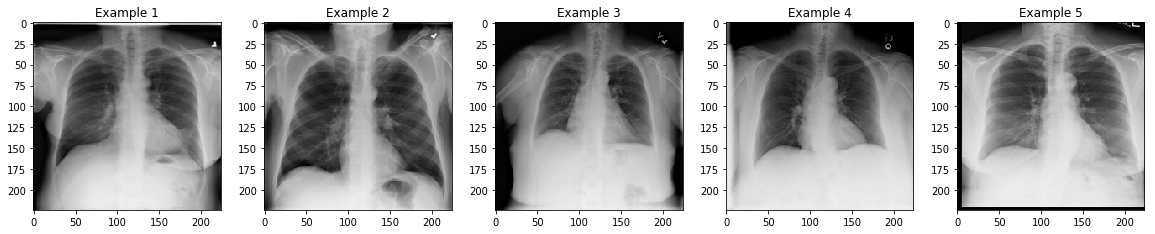

In [49]:
example_NoF = list(data_dir.glob('train/No Finding/*.jpg'))
i = 1
plt.figure(figsize=(20,20))
for n in example_NoF[:5]:
    ex = Image.open(n)
    ex_ar = np.asarray(ex)
    plt.subplot(5,5,i)
    word = "Example "+ str(i)
    plt.title(word)
    plt.imshow(ex_ar)
    i+=1

In [5]:
#Preproccsing image data into ImageDataGenerator
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + "/train/"
TEST_PATH = PATH + "/test/"

#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME))
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME))

x_train,y_train = next(data_gen_train)
x_test,y_test = next(data_gen_test)

Found 4088 images belonging to 6 classes.
Found 1022 images belonging to 6 classes.


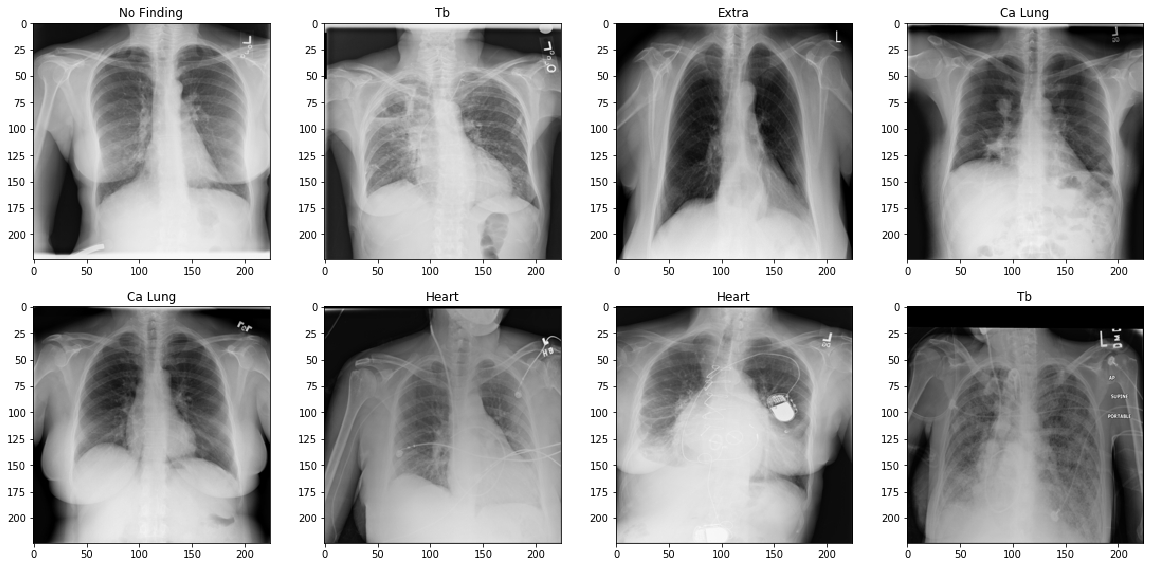

In [7]:
plt.figure(figsize=(20,20))
for n in range(8):
    plt.subplot(4,4,n+1)
    plt.title(CLASS_NAME[y_train[n]==1][0].title())
    plt.imshow(x_train[n])

In [11]:
#Try to load InceptionV3
myInception = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=6)
#for layer in myInception.layers:
#    layer.trainable = False

In [12]:
out = myInception.output
out = layers.GlobalAveragePooling2D()(out)
out = layers.Dense(1024,activation='relu')(out)
out = layers.Dense(512,activation='relu')(out)
out = layers.Dropout(0.3)(out)
out = layers.Dense(1,activation='hard_sigmoid')(out)

myModel = Model(myInception.input,out)

In [13]:
#myModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [14]:
myModel.compile(loss='binary_crossentropy',
                    optimizer='sgd',metrics=['accuracy'])

In [ ]:
#Try to fit data into our model
session = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_test,
                               epochs = 200,
                               validation_steps = 20,
                               verbose = 1,)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128 steps, validate for 32 steps
Epoch 1/200
  3/128 [..............................] - ETA: 33:08 - loss: 0.5151 - accuracy: 0.8333

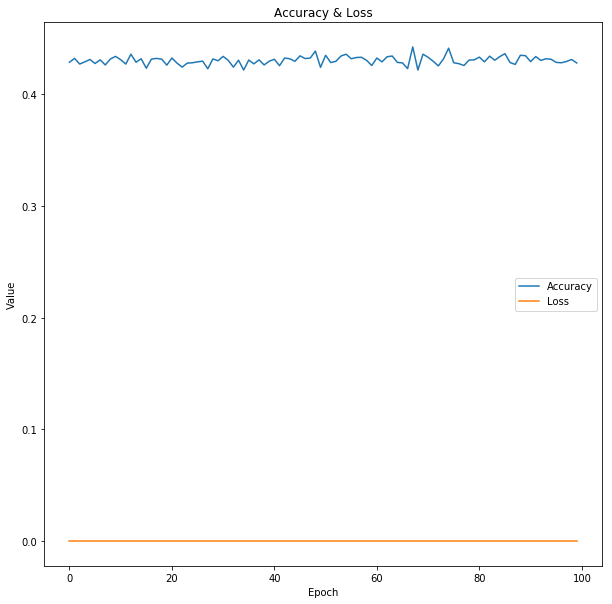

In [67]:
plt.figure(figsize=(10,10))
plt.plot(session.history['accuracy'])
plt.plot(session.history['loss'])
plt.title('Accuracy & Loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'])
plt.show()

In [75]:
test_session = myModel.predict_generator(data_gen_test,np.ceil(1022/32))

In [86]:
num = 0
for i in range(0,test_session.size):
    if(test_session[i] > 0.8):
        num+=1
num

82